In [1]:
%%writefile Sample_Tools.py

import os 
import sys 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import QUANTAXIS as QA
from QUANTAXIS.QAData.financial_mean import financial_dict
from QUANTAXIS.QAUtil.QAParameter import MARKET_TYPE, RUNNING_ENVIRONMENT, ORDER_DIRECTION
from QUANTAXIS.QAUtil import  trade_date_sse

from QUANTAXIS.QAData.data_marketvalue import QA_data_marketvalue
from QUANTAXIS.QAUtil import (
        DATABASE,
        QA_util_code_tolist,
        QA_util_date_stamp,
        QA_util_date_valid,
        QA_util_log_info,
)

from QUANTAXIS.QAUtil.QADate_trade import (
    QA_util_get_pre_trade_date,
    QA_util_get_next_trade_date,
    QA_util_if_tradetime
)

import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats as st
import numpy as np
import pandas as pd

import time
import datetime
import re

from base.JuUnits import excute_for_multidates
import base.JuUnits as u

mpl.rcParams['font.sans-serif'] = ['SimHei','KaiTi', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
mpl.rcParams['font.size'] = 14  # 字体大小
mpl.rcParams['axes.unicode_minus'] = False  # 正常显示负号

from sklearn.neighbors import KernelDensity  




########### data #################
def get_data(codes_list, start=None, end=None, gap=60, freq=QA.FREQUENCE.DAY, market=MARKET_TYPE.STOCK_CN):
    ''':param freq： --只能比day频率高，需要更低频需要从day重新采样。
    '''
    assert ((not start is None) or (not end is None)), 'start 和 end 必须有一个'
    if start is None:
        start_ = QA_util_get_next_trade_date(end, gap*-1)  # trade_date_sse[trade_date_sse.index(end) - gap]
    else:
        start_ = start
    if end is None:
        end_ = QA_util_get_next_trade_date(start, gap)# trade_date_sse[trade_date_sse.index(start) + gap]
    else:
        end_ = end
        
    if freq == QA.FREQUENCE.DAY:
        data = QA.QA_fetch_stock_day_adv(codes_list, start_, end_)
    else:
        data = QA.QA_fetch_stock_min_adv(codes_list, start_, end_,frequence=freq)

            
#     data = QA.QA_quotation(codes_list, start_, end_, source=QA.DATASOURCE.MONGO,
#                                frequence=freq, market=market, 
#                                output=QA.OUTPUT_FORMAT.DATASTRUCT)
    return data

def excute_priod_limit(stocks_df, limit=60):
    '''排除数据（交易天数or时间）过少的数据
    :param stocks_df: {pd.DataFrame 或 stock_struct}
    :param limit: {int} --数据量（天数）限制
    :return: {pd.DataFrame} --返回原数据对象的指针，未新建对象
    '''
    count = excute_for_multidates(stocks_df, lambda x:x.shape[0],level='code')
    exclude = count[x<=limit]
    if exclude.count() == 0:
        return stocks_df
    excluded_codes = stocks_df.index.get_level_values('code').difference(exclude.index)
    return stocks_df.loc[(slice(None),exclude_new),]

def get_index_data(code, start=None, end=None, gap=60, freq=QA.FREQUENCE.DAY):
    ''':param freq： --只能比day频率高，需要更低频需要从day重新采样。
    '''
    assert ((not start is None) or (not end is None)), 'start 和 end 必须有一个'
    if start is None:
        start_ = QA_util_get_next_trade_date(end, gap*-1)(end, gap*-1)  # trade_date_sse[trade_date_sse.index(end) - gap]
    else:
        start_ = start
    if end is None:
        end_ = QA_util_get_next_trade_date(start, gap)# trade_date_sse[trade_date_sse.index(start) + gap]
    else:
        end_ = end
        
    if freq == QA.FREQUENCE.DAY:
        data = QA.QA_fetch_index_day_adv(code, start_, end_)
    else:
        data = QA.QA_fetch_index_min_adv(code, start_, end_,frequence=freq)

    return data

def resample_stockdata_low(stock_df,freq="M"):
    '''低频数据重新按时间降采样, 月周天采样
        :param freq：{str} --in[?D，?w, ?M, Q]
        注：day采样取左, week,month取右
    '''
    if np.sum([char in ["d",'D'] for char in list(freq)])>0:
        tmp = stock_df.groupby(level=1).apply(lambda x: x.reset_index('code',drop=True).resample(freq,closed='left', label='left').first())
        tmp = tmp.dropna()
    else:
        tmp = stock_df.groupby(level=1).apply(lambda x: x.reset_index('code',drop=True).resample(freq,closed='right', label='right').last())
    #groupby level=1，导致index顺序翻转，转回原index顺序
    return tmp.reset_index().set_index(['date','code'])

def resample_stockdata_high(stock_df,freq="5min"):
    '''高频数据重新按时间降采样 
    '''
    pass

def get_stock_name(code):
    if isinstance(code, list):
        return QA.QA_fetch_stock_name(code).name
    if isinstance(code, str):
        return QA.QA_fetch_stock_name(code)
    raise TypeError('code MUST BE list or str')

    
########### samples #################
def get_codes_by_zs(name='沪深300', only_main=True,filter_st=True):
    codes_list = get_codes_by_market(codes_list=get_blocks_view('zs')[name], sse='all',only_main=only_main,filter_st=filter_st)
    return codes_list

def get_sample_by_zs(name='沪深300', start=None, end=None, gap=60, freq=QA.FREQUENCE.DAY, only_main=True, filter_st=True):
    codes_list = get_codes_by_zs(name, only_main=only_main,filter_st=True)
    data = get_data(codes_list, start=start, end=end, gap=gap, freq=freq, market=MARKET_TYPE.STOCK_CN)
    return data


  
########### benchmark samples #################
def get_benchmark(name=None, code=None, start=None, end=None, gap=60, freq=QA.FREQUENCE.DAY):
    '''优先name，如果name不为空，但未查询到，会报错处理
    '''
    assert ((not name is None) or (not code is None)), 'name 和 code 必须有一个'
    assert ((not start is None) or (not end is None)), 'start 和 end 必须有一个'
    
    code_ = code
    if name is not None:
        index_list = QA.QA_fetch_index_list_adv()
        target = index_list[index_list['name']==name]
        assert len(target) > 0 , "name: %s 未查询到" % name
        code_ = target.code.tolist()
        if name == '沪深300':
            # 沪深300会查出上证和深证的两个代码，
            code_ = code_[0:1]
    
    return get_index_data(code_, start=start, end=end, gap=gap, freq=freq)

    
########### indicator #################
def get_forward_return(stocks_df,column):
    '''计算(未来)下一个回报率
    :param stocks_df: {pd.DataFrame 或 stock_struct}
    :param column: {string}
    :return: {pd.Series}
    '''
    ret = stocks_df[column].groupby(level=1, group_keys=False).apply(lambda x:(x/x.shift(1)-1).shift(-1))
    ret.name = 'ret_forward'
    return ret

def get_current_return(stocks_df,column,stride=1):
    '''计算当期的回报率
    :param stocks_df: {pd.DataFrame 或 stock_struct}
    :param column: {str} --用于计算收益的列名
    :param stride: {int} --计算收益的跨度
    注意：当期回报有可能也包含未来信息。
    '''
    ret = stocks_df[column].groupby(level=1, group_keys=False).apply(lambda x:(x/x.shift(stride)-1))
    ret.name = 'ret'
    return ret

def get_future_period_return(stocks_df,column,forward_window,method='sum'):
    '''计算未来一定区间的（某种总）回报率
    :param stocks_df: {pd.DataFrame 或 stock_struct}
    :param column: {string}
    :param forward_window: {int} --前望窗口长度
    :param method: {str in ['mean', 'sum', 'std', 'median', 'skew', 'kurt', 'min', 'max']} --计算方法，
    :return: {pd.Series}
    '''
    assert method in ['mean', 'sum', 'std', 'median', 'skew', 'kurt', 'min', 'max'], "method MUST Be one of ['mean', 'sum', 'std', 'median', 'skew', 'kurt', 'min', 'max']}"
    def calc(x):
        ret = (x/x.shift(1)-1).shift(-1)
        if method in ['sum']:
            ret = np.log(ret+1)
            
        ret = ret[::-1].rolling(forward_window).agg(method)[::-1]
        
        if method in ['sum']:
            ret = np.exp(ret)-1
        
        return ret
        
    ret = stocks_df[column].groupby(level=1, group_keys=False).apply(calc)
    ret.name = 'ret_future_'+str(forward_window)+'_'+method
    return ret

def get_rank(data, codes=None,quantile=False, column=None):
    '''get_rank(a,['000001','000002'],column=['totalAssets','ROE'])'''
    if len(data.index.names) >= 2:
        res = excute_for_multidates(data, lambda x: x.rank(ascending=False,pct=quantile))
        if codes:
            if column:
                res=res.loc[pd.IndexSlice[:,codes], column]
            else:
                res=res.loc[pd.IndexSlice[:,codes],slice(None)]
    else:
        res =  data.rank(ascending=False,pct=quantile)
        if codes:
            res = res.loc[codes]
    return res

def add_industry(stocks_df, hy_source='swhy', inplace=True):
    '''向stock的DataFrame中插入行业数据
        :param stocks_df: --stock的DataFrame
        :param hy_source: {str in ['gn', 'tdxhy', 'zs', 'fg', 'swhy' 'yb', 'csindex']} --指明数据来源
        :param inplace:{bool} --是否在原对象上修改,建议用true，效率高（default:True）
       :return: {pd.DataFame}
    '''
    industry = get_blockname_from_stock(stocks_df.index.levels[1].to_list(), hy_source)
    if inplace:
        stocks_df['industry'] = stocks_df.index.get_level_values(1).map(industry)
        return stocks_df
    else:
        return stocks_df.assign(industry=stocks_df.index.get_level_values(1).map(industry))

def add_report_inds(data_df, inds_names=['totalCapital']):
    codes = data_df.index.get_level_values(1).unique().tolist()
    date_ = data_df.index.get_level_values(0)
    date_start = get_pre_report_date(date_.min())
    date_end = get_next_report_date(date_.max())
    report_df = QA.QA_fetch_financial_report_adv(codes, date_start,date_end,ltype='EN').data[inds_names]

    data_ = pd.concat([data_df,report_df], axis=1)
    data_[inds_names] = excute_for_multidates(data_[inds_names],lambda x:x.fillna(method='ffill'),level=1)
    
    return data_.loc[data_df.index]

def add_marketvalue_industry(df:pd.DataFrame, static_mv:bool=False):
    '''市值，行业-中性化：
        :param df：{pd.DataFrame} --需要中性化的指标
        :param static_mv：{bool} --是否使用静态市值，静态市值取自财报， 动态市值通过复权信息和收盘价进行计算。
            静态市值时，DataFrame中必须含有close
        注意：动态市值区分总股本和流动股本。totalCapital 和 liquidity_totalCapital
    '''  
    df_ = df
    if not isinstance(df, pd.DataFrame):
        df_ = pd.DataFrame(df)
        
    # 静态市值取自财报， 动态市值通过复权信息和收盘价进行计算。
    if static_mv:
        df_reported = add_report_inds(df_, inds_names=['totalCapital'])
        df_reported['totalCapital'] = df_reported['totalCapital']*df_reported['close']
        df_reported.rename(columns=lambda x:x.replace('totalCapital','market_value'), inplace=True)
    else:
        df_reported = QA_data_marketvalue(df_)
        df_reported.rename(columns=lambda x:x.replace('mv','market_value'), inplace=True)
        
    add_industry(df_reported)
    
    df_reported.dropna(axis=0,inplace=True)
    df_reported.drop(df_reported[df_reported['market_value']==0].index,inplace=True)

    return df_reported

########### block #################
def get_all_blocks(hy_source='swhy', collections=DATABASE.stock_block):
    a = QA.QA_fetch_stock_block_adv(collections=collections).data
    return a[a['type']==hy_source].index.get_level_values('blockname').unique().to_list()

def get_blocks_view(hy_source, collections=DATABASE.stock_block):
    ''' 获取行业视图，既行业以及对应的code
        :param hy_source: {str in ['gn', 'tdxhy', 'zs', 'fg', 'swhy' 'yb', 'csindex', 'concept', 'industry']} --指明数据来源
        其中'concept', 'industry' 在表DATABASE.stock_block_em中
    
    '''
    if not hy_source in ['gn', 'tdxhy', 'zs', 'fg', 'swhy', 'yb', 'csindex', 'concept', 'industry']:
        raise TypeError('hy_source MUST BE [gn|tdxhy|zs|fg|swhy|yb|csindex|concept|industry]')

#     a = QA.QA_fetch_stock_block_adv().data
#     blocks_view = a[a['type'] == hy_source].groupby(level=0).apply(
#         lambda x:[item for item in x.index.remove_unused_levels().levels[1]]
#     )
    a = QA.QA_fetch_stock_block(collections=collections)
    blocks_view = a[a['type'] == hy_source].groupby('blockname').apply(lambda x:x.index.to_list())
    return blocks_view

def get_blockname_from_stock(code, hy_source='swhy', collections=DATABASE.stock_block):
    code_ = code
    if isinstance(code, str):
        code_ = [code]
    try:
        res = QA.QA_fetch_stock_block(code=code_, collections=collections)
    except Exception as e:
        print(e,'get_stock_blockname ：code error')
        return None
    return res[res['type']==hy_source]['blockname']

def get_codes_from_blockname(blockname, sse='all', only_main=True, filter_st=True, collections=DATABASE.stock_block):
    codes = QA.QA_fetch_stock_block_adv(blockname=blockname, collections=collections).code
    if len(codes)!=0:
        codes = get_codes_by_market(codes_list=codes, sse=sse, only_main=only_main,filter_st=filter_st)
    return codes

def get_codes_by_market(codes_list=None, sse='sh',only_main=True,filter_st=True):
    '''按照市场获取股票代码，分为3类sh，sz，all，默认只获取主板；
       :param codes_list: --为空时，从全市场codes中获得整个子市场的codes;
                            不为空时，则过滤codes_list的内容;
                          (default: None)
       :param sse:{str in ['all', 'sh', 'sz']} --市场名称
       :param only_main:{bool} --是否主板，True时，过滤创业板内容。(default: True)
       :param filter_st:{bool} --是否过滤ST，仅在codes_list为空的时候生效。(default: True)
    '''
    condition = []
    if sse =='all':
        condition.append('60')
        condition.append('00')
        if not only_main:
            condition.append('30')
            condition.append('68')
    if sse == 'sh':
        condition.append('60')
        if not only_main:
            condition.append('68')
    if sse == 'sz':
        condition.append('00')
        if not only_main:
            condition.append('30')
            
    assert len(condition), '参数错误，检查sse内容'
    
    stocks = QA.QA_fetch_stock_list()
    if codes_list is None:
        if filter_st:
            stocks = stocks[~stocks.name.str.startswith('ST')]
        return stocks[stocks.code.map(lambda x:x[0:2] in condition)].code.unique().tolist()
    else:
        stocks = stocks[stocks.index.isin(codes_list)]
        if filter_st:
            stocks = stocks[~stocks.name.str.startswith('ST')]
        return stocks[stocks.code.map(lambda x:x[0:2] in condition)].code.unique().tolist()

    
    
###############  financial  #########################
def get_quarter_list(start_year, end_year, quarter_ordesr=[1,2,3,4], generate_label=False):
    '''生成财报季报的发布日期，
       :param start_year:{int|str} --起始年份;
       :param end_year:{int|str} --结束年份;
       :param quarter_ordesr:{list[int] in [1, 2, 3, 4]} --季度标识，标识需要产生哪个季度的日期;         
       :param generate_label:{bool} --是否生成季度标签。(default: False)
       :return：{list,tuple[list]} -- 默认返回季报发布日期，
                                      如果generate_label=True时返回tuple(date,label)，
    '''
    if len(set(quarter_ordesr).union([1,2,3,4])) > 4:
        raise TypeError('quarter_ordesr MUST IN [1|2|3|4]')
        
    date_element = ['-03-31', '-06-30', '-09-30', '-12-31']
    lables = ['Q1', 'Q2', 'Q3', 'Q4']
    
    res_date = []
    res_lables = []
    for order in np.array(quarter_ordesr)-1:
        res_date.extend([str(y)+date_element[order] for y in range(int(start_year), int(end_year)+1)])
        if generate_label:
            res_lables.extend([str(y)+lables[order] for y in range(int(start_year), int(end_year)+1)])
            
    res_date.sort()
    if generate_label:
        res_lables.sort()
        return res_date,res_lables
    return res_date

def get_next_report_date(cur_date):
    cur_date_ = cur_date
    if isinstance(cur_date, pd.Timestamp):
        cur_date_ = cur_date.strftime('%Y-%m-%d')
        
    assert len(re.findall(r"(\d{4}-\d{2}-\d{2})",cur_date_)) > 0, '日期格式必须为：xxxx-xx-xx；当前输入：%s' % cur_date_
    
    year = cur_date_[0:4]
    month_day = cur_date_[4:10]
    date_element = ['-03-31', '-06-30', '-09-30', '-12-31']
    if month_day in date_element:
        index = date_element.index(month_day)
        next_index = index +1 if index != 3 else 0
        year = str(int(year)+1) if next_index==0 else year
        return year+date_element[next_index]
    else:
        month = cur_date_[5:7]
        date_element = ['-03-31','-03-31','-03-31','-03-31','-06-30','-06-30','-06-30','-09-30','-09-30','-09-30','-12-31','-12-31','-12-31']
        return year+date_element[int(month)]

def get_pre_report_date(cur_date, keep_current=True):
    cur_date_ = cur_date
    if isinstance(cur_date, pd.Timestamp):
        cur_date_ = cur_date.strftime('%Y-%m-%d')
        
    assert len(re.findall(r"(\d{4}-\d{2}-\d{2})",cur_date_)) > 0, '日期格式必须为：xxxx-xx-xx；当前输入：%s' % cur_date_
    
    year = cur_date_[0:4]
    month_day = cur_date_[4:10]
    date_element = ['-03-31', '-06-30', '-09-30', '-12-31']
    if month_day in date_element:
        if keep_current:
            return cur_date # 当前正好是report_date的返回。
        index = date_element.index(month_day)
        pre_index = index-1 if index >=0 else 3
        year = str(int(year)-1) if pre_index==3 else year
        return year+date_element[pre_index]
    else:
        month = cur_date_[5:7]
        date_element = ['-12-31','-12-31','-12-31','-12-31','-03-31','-03-31','-03-31','-06-30','-06-30','-06-30','-09-30','-09-30','-09-30']
        if int(month) <=3:
            return str(int(year)-1)+date_element[int(month)]
        return year+date_element[int(month)]
    
###############  other  #########################
def optimize_data_type(data):
    columns = data.columns
    roles = {'open':np.float32,'high':np.float32,'low':np.float32,'close':np.float32,
             'adj':np.float32,'industry':'string[pyarrow]'}
    for key in roles.keys():
        if key in columns:
            data[key]=data[key].astype(roles[key])


In [3]:
%%time
get_all_blocks(hy_source='zs')
# data = hs300(end="2020-01-06", gap=2200).data
# # ret = get_current_return(data,'close')
# # get_forward_return(stocks_df,column)
# add_industry(data, hy_source='swhy', inplace=True)
# print(data.loc[pd.IndexSlice[:,'002415'],:])

# print(data.index.levels[1].to_list())
# # print(get_blocks_view('zs')['沪深300'])
# print(QA.QA_fetch_stock_block(code=data.index.levels[1].to_list()))
# print(get_blockname_from_stock(data.index.levels[1].to_list(),hy_source='swhy'))
# print(data.index.get_level_values(1).map(get_blockname_from_stock(data.index.levels[1].to_list(),hy_source='swhy')))
# data['a'] = data.index.get_level_values(1).map(get_blockname_from_stock(data.index.levels[1].to_list(),hy_source='swhy'))
# print(data)

Wall time: 808 ms


['精选指数',
 '沪深300',
 '深证成指',
 '创业板指',
 '深证50',
 '上证50',
 '科创50',
 '北证50',
 '中证A50',
 '中证A100',
 '中证100',
 '中证200',
 '中证龙头',
 '中证央企',
 '中证红利',
 '中证回购',
 '红利低波',
 '深主板50',
 '创业大盘',
 '创业板50',
 '创业200',
 '创业300',
 '创业小盘',
 '创业创新',
 '创业蓝筹',
 '创成长',
 '创质量',
 '创科技',
 '创医药',
 '300周期',
 '300非周',
 '300ESG',
 '大盘成长',
 '大盘价值',
 '中盘成长',
 '中盘价值',
 '小盘成长',
 '小盘价值',
 '央企100',
 '上证380',
 '上证180',
 '上证中盘',
 '上证红利',
 '上证治理',
 '上证超大',
 '上证混改',
 '上证创新',
 '中小100',
 '中小300',
 '深证100',
 '深证300',
 '深证成长',
 '深证红利',
 '深证治理',
 '深证价值',
 '深次新股',
 '深证创新',
 '消费100',
 '资源优势',
 '国证成长',
 '国证价值',
 '国证服务',
 '国证红利',
 '国证治理',
 '国证基建',
 '国证农业',
 '能源金属',
 '国证芯片',
 '国证算力',
 '民企100',
 '在线消费',
 '新硬件',
 '科技100',
 '银河99',
 '中创100',
 '央视50',
 '腾讯济安',
 '中华A80',
 '能源互联',
 '金融科技',
 '富时A50',
 'MSCIA50',
 '半导体50',
 '投资时钟',
 '双创50',
 '区块链50',
 '创新100',
 '农业50',
 '科创100',
 '科创信息',
 '科创生物',
 '科创芯片',
 '科创高装',
 '科创材料',
 '科创成长',
 '环保50',
 '国信价值',
 '内地低碳',
 '内地绿电',
 '新兴成指',
 '国企改革',
 '数字经济',
 '长三角',
 '珠三角',
 '环渤海',
 '分析师指',
 '科创国企']

In [19]:
get_blockname_from_stock()

QA Error QA_fetch_stock_day_adv parameter code=600918 , start=2010-12-21, end=2020-01-06 call QA_fetch_stock_day return None


In [50]:
get_blocks_view('swhy')

blockname
LED     [002449, 002992, 300102, 300232, 300241, 30026...
专业工程    [000065, 000498, 000779, 000928, 000961, 00206...
专业连锁    [000026, 000587, 000759, 000829, 002024, 00225...
专用汽车                     [600262, 600375, 601238, 601633]
丝绸                                       [002404, 600232]
                              ...                        
餐饮                       [000721, 002186, 002306, 605108]
饲料      [000048, 000702, 000876, 002100, 002124, 00215...
高速公路    [000429, 000548, 000828, 000885, 000886, 00090...
黄酒                               [600059, 600616, 601579]
黄金      [000506, 000975, 002155, 002237, 600311, 60038...
Length: 203, dtype: object

In [33]:

# codes_list = get_blocks_view('zs')['沪深300']
# data = get_data(codes_list, end='2021-06-28', gap=500)
# d2 = resample_stockdata_low(data.data,freq="Q")
# set(d2.index.get_level_values('date'))

get_sample_by_zs(name='上证50', end='2020-06-29', gap=200, only_main=True).data

open    high     low   close     volume        amount
date       code                                                           
2019-08-27 600000   11.37   11.57   11.30   11.30   662474.0  7.566641e+08
           600009   87.68   88.90   87.50   87.50    66932.0  5.899895e+08
           600016    5.80    5.87    5.79    5.82  1028800.0  6.002615e+08
           600028    4.98    5.03    4.97    4.99   759488.0  3.801560e+08
           600030   22.41   23.04   22.35   22.77  1355030.0  3.082742e+09
...                   ...     ...     ...     ...        ...           ...
2020-06-29 601899    4.37    4.44    4.30    4.37  1917051.0  8.362458e+08
           603259   94.80   97.46   94.29   96.97   179775.0  1.720271e+09
           603288  123.79  125.30  122.62  124.65    50701.0  6.283532e+08
           603501  204.79  205.50  197.96  199.83    62148.0  1.245702e+09
           603986  240.90  242.50  230.20  233.78   146672.0  3.450274e+09

[9648 rows x 6 columns]

In [1]:
# get_Q4_list(2012,2019)


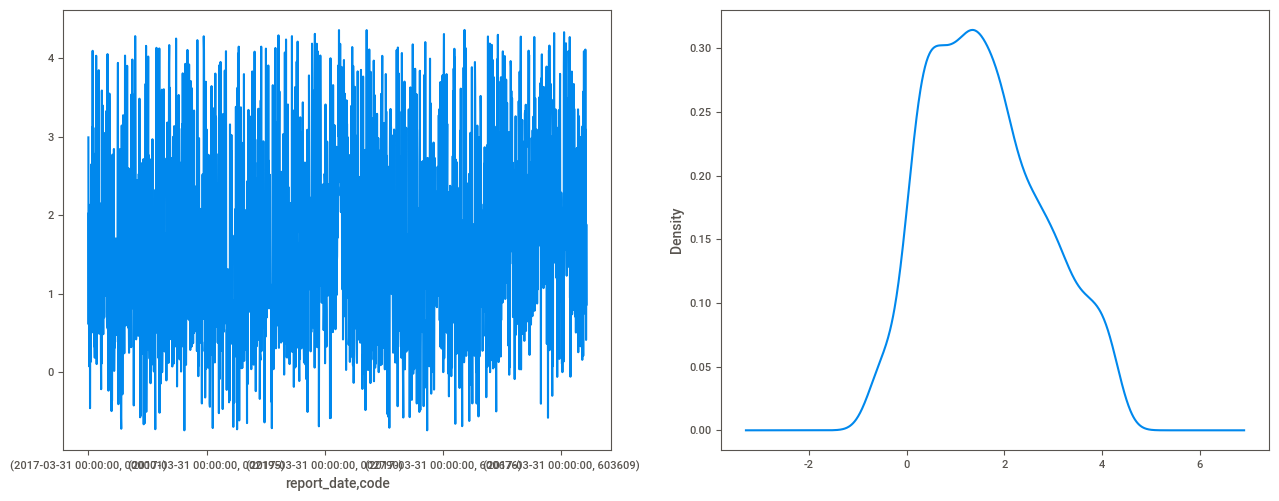

In [66]:
fig = plt.figure(figsize=(1120/72,420/72))
finances_filted['ROE'].plot(ax=fig.add_subplot(1,2,1))
# plt.scatter(finances_filted['ROE'].index.get_level_values('code'),finances_filted['ROE'].values)
finances_filted['ROE'].plot(kind="kde",ax=fig.add_subplot(1,2,2))
# finances_filted['ROE'].describe()
# finances_filted['totalAssets'].mean()
# plt.show()


In [30]:
QA.QA_fetch_stock_block?

Signature: QA.QA_fetch_stock_block(code=None, format='pd', collections=Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'quantaxis'), 'stock_block'))
Docstring: <no docstring>
File:      d:\pyprojects\quantaxis\quantaxis\qafetch\qaquery.py
Type:      function
